In [1]:
%load_ext Cython

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm import tqdm
from scipy.special import erfc
import boost_histogram as bh

from lmfit.models import *
from lmfit import Model

from nicks_plot_utils import *

import inspect

COLOR_BLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COLOR_RED=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COLOR_DGREEN=plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

In [3]:
golden_df = pd.read_csv("/Users/tylern/Data/e1d/gr_empty.csv")
print(len(golden_df))
#golden_df = golden_df.groupby(golden_df['run_num'], as_index=False).aggregate({'run_num': 'first', 'num_elec': 'sum', 'num_of_events': 'sum', 'total_q': 'sum'})
golden_df['ratio'] = golden_df['num_elec'] / golden_df['total_q']
# golden_df['ratio'] = golden_df['_ratio']
golden_df['run'] = golden_df.run_num*10 + golden_df.file_num
golden_df = golden_df.sort_values(by=['run_num', 'file_num']).reset_index()
# golden_df = golden_df.sort_values(by=['run_num']).reset_index()
# golden_df['sum_q'] = np.cumsum(golden_df['total_q'])

golden_df.head()

53


,index,run_num,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run
0,0,22880,2,0,725,0.004100,176829.484375,0.000000,228802
1,1,22882,0,2744,156970,58.069199,2703.154297,47.253967,228820
2,2,22882,1,2778,158346,60.017204,2638.343506,46.286728,228821
3,3,22882,2,2858,160348,61.684097,2599.503174,46.332850,228822
4,4,22882,3,365,21565,8.157104,2643.707764,44.746270,228823


In [4]:
run_list = pd.read_csv("/Users/tylern/Data/e1d/out.csv").rename(columns={"Run Id": "run_num"})
run_list['Number of Events'] = pd.to_numeric(run_list['Number of Events'], errors='coerce')
run_list.head()

,run_num,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,22678,2000-01-31 10:16:00.0,1645.03,0.0,0.977,0,27380.0,e_calib_misc,56Fe
1,22679,2000-01-31 10:29:00.0,1645.03,0.0,0.977,0,32546.0,e_calib_misc,56Fe
2,22680,2000-01-31 10:35:00.0,1645.03,0.0,0.977,0,555588.0,e_calib_misc,56Fe
3,22681,2000-01-31 14:47:00.0,1645.03,0.0,-0.977,0,980.0,e_calib_misc,other
4,22682,2000-01-31 14:52:00.0,1645.03,0.0,0.977,0,1133.0,e_calib_misc,other


In [5]:
golden = pd.merge(golden_df, run_list, on='run_num')
#golden = golden_df
golden = golden[golden.Target == "empty"]
#golden = golden[(golden.Target == "H2_full") & (golden["Run Type"] == 'beam_electron')]
golden.dropna(inplace=True)
print(len(golden))
golden.head(10)

53


,index,run_num,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,22880,2,0,725,0.004100,176829.484375,0.000000,228802,2000-02-04 22:58:00.0,4817.26,35.0,3374.85,5996,1344746.0,beam_electron,empty
1,1,22882,0,2744,156970,58.069199,2703.154297,47.253967,228820,2000-02-04 23:44:00.0,4817.26,35.0,3374.85,5996,1605311.0,beam_electron,empty
2,2,22882,1,2778,158346,60.017204,2638.343506,46.286728,228821,2000-02-04 23:44:00.0,4817.26,35.0,3374.85,5996,1605311.0,beam_electron,empty
3,3,22882,2,2858,160348,61.684097,2599.503174,46.332850,228822,2000-02-04 23:44:00.0,4817.26,35.0,3374.85,5996,1605311.0,beam_electron,empty
4,4,22882,3,365,21565,8.157104,2643.707764,44.746270,228823,2000-02-04 23:44:00.0,4817.26,35.0,3374.85,5996,1605311.0,beam_electron,empty
5,5,22930,0,1994,136295,31.095201,4383.152344,64.125650,229300,2000-02-06 20:37:00.0,4817.26,35.0,3374.85,5995,1600118.0,beam_electron,empty
6,6,22930,1,1990,138219,31.345900,4409.476074,63.485178,229301,2000-02-06 20:37:00.0,4817.26,35.0,3374.85,5995,1600118.0,beam_electron,empty
7,7,22930,2,2022,134303,30.761803,4365.901367,65.730868,229302,2000-02-06 20:37:00.0,4817.26,35.0,3374.85,5995,1600118.0,beam_electron,empty
8,8,23048,0,2005,133426,21.825502,6113.307129,91.865010,230480,2000-02-10 08:52:00.0,4817.26,34.8,3374.85,5996,1075968.0,beam_electron,empty
9,9,23048,1,1864,131473,21.371201,6151.876953,87.220182,230481,2000-02-10 08:52:00.0,4817.26,34.8,3374.85,5996,1075968.0,beam_electron,empty


1211.0596144795418

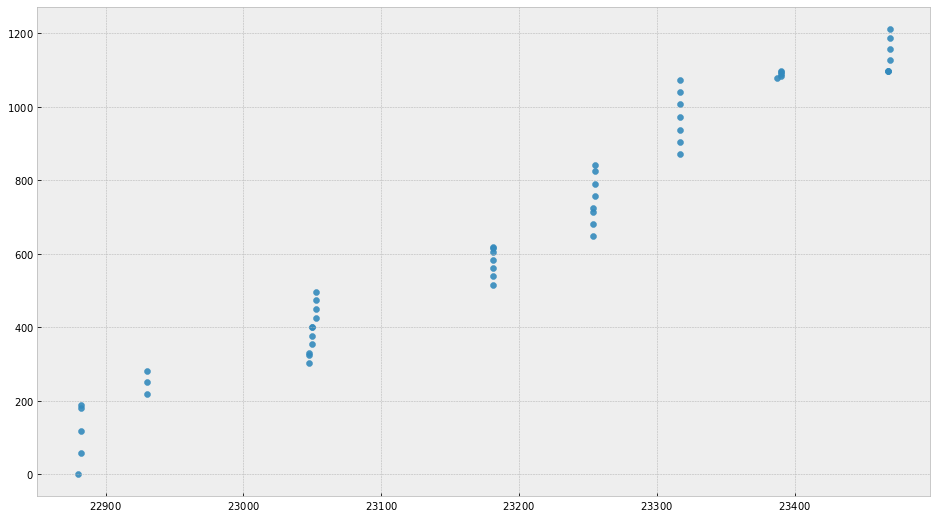

In [6]:
plt.scatter(golden['run_num'], np.cumsum(golden['total_q']), alpha=0.9);

np.sum(golden['total_q'])

Parameters([('amplitude', <Parameter 'amplitude', value=0.0, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=6000.0, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=490.0, bounds=[0.0:inf]>), ('fwhm', <Parameter 'fwhm', value=1153.8618000000001, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=0.0, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])


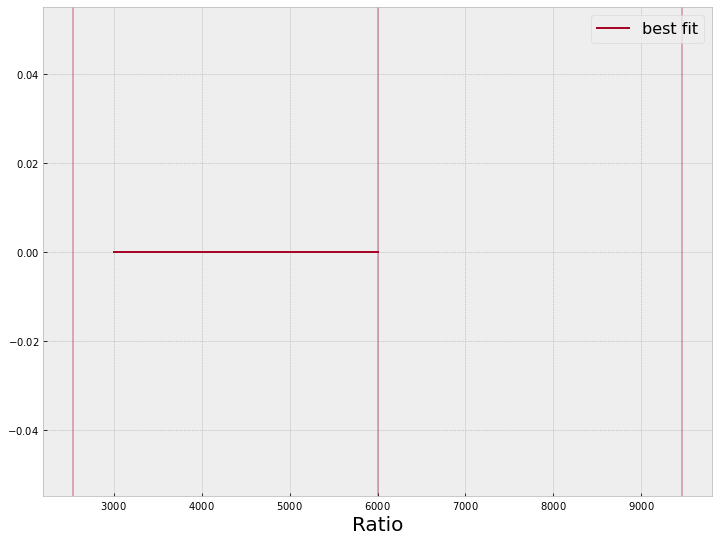

In [7]:
SIGMA = 3
fig = plt.figure(figsize=(12,9), facecolor='w', edgecolor='k')
bin_heights, bin_borders, _ = plt.hist(golden['ratio'], bins=50, histtype='stepfilled', alpha=0.9, range=[3_000, 6_000])

x = bin_borders[:-1]
y = bin_heights

mod = GaussianModel()
pars = mod.guess(y, x=x)
pars['center'].set(value=6_000)
out = mod.fit(y, pars, x=x)

xs=np.linspace(3_000, 6_000, 140)

plt.plot(xs, out.eval(x=xs), COLOR_RED, label='best fit')

center = out.params['center'].value
fwhm = out.params['fwhm'].value

print(out.params)

plt.axvline(x=center, c=COLOR_RED, alpha=0.3)
plt.axvline(x=center+SIGMA*fwhm, c=COLOR_RED, alpha=0.3)
plt.axvline(x=center-SIGMA*fwhm, c=COLOR_RED, alpha=0.3)

#plt.ylim(0)
plt.xlabel('Ratio')
plt.legend()
plt.show()

6000.0


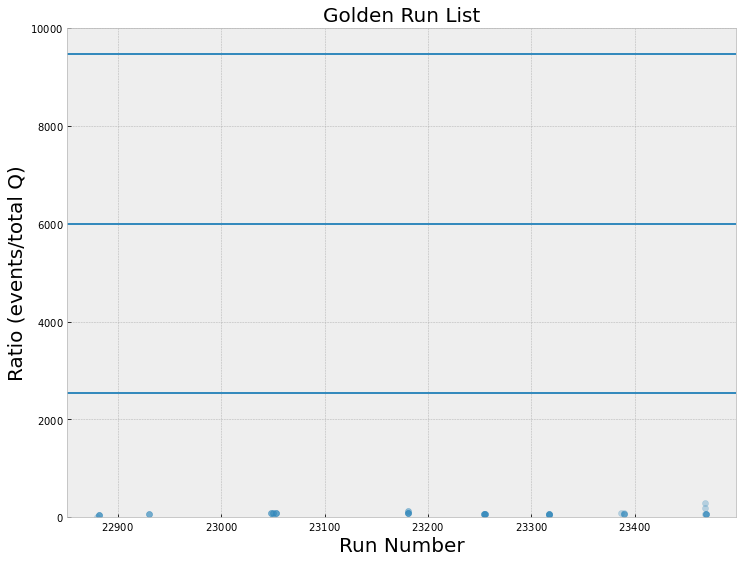

In [8]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden['run_num'], golden['ratio'], alpha=0.3)
print(center)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 10_000])
plt.show()


In [9]:
# runs = golden[(golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)].run_num
# cut_out = golden[~golden.run_num.isin(runs.values)]
# after_cut = golden[golden.run_num.isin(runs.values)]

runs = (golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)
cut_out = golden[~runs]
after_cut = golden[runs]


print(len(after_cut))
after_cut.head()

0


,index,run_num,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target


NameError: name 'empty' is not defined

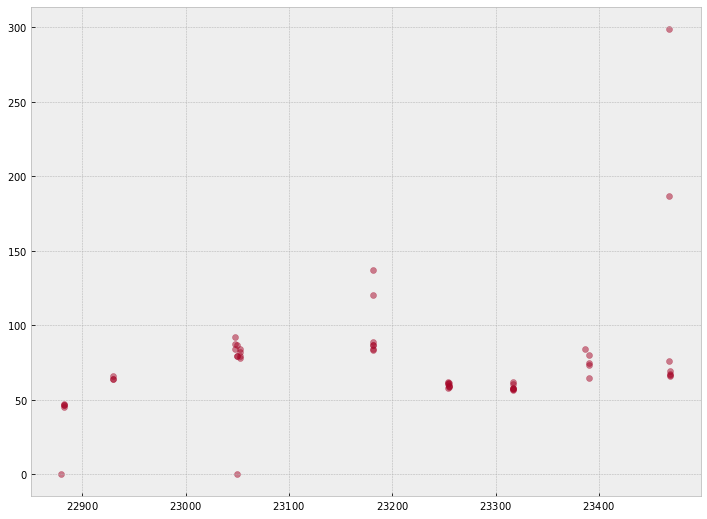

In [10]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(after_cut['run_num'], after_cut['ratio'], alpha=0.5)
plt.scatter(cut_out['run_num'], cut_out['ratio'], alpha=0.5)
plt.scatter(empty['run_num'], empty['ratio'], alpha=0.5)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden File List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 10_000])
plt.show()


fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden.index, np.cumsum(golden['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(golden.total_q))}')
plt.scatter(after_cut.index, np.cumsum(after_cut['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(after_cut.total_q))}')
plt.legend()
plt.show()


print(Q_tot := np.max(np.cumsum(after_cut.total_q)))
#print(Q_tot := np.max(np.cumsum(golden.total_q)))




In [ ]:
def luminosity(Q_tot=3000):
    # Q_tot = 15623.89E-6  # mC E-6 -> C
    Q_tot *= 1E-6
    # Q_tot = 2906.9858369E-6 # 2nd attempt
    # Q_tot = 2742.5087E-6 # 1st attempt
    l = 5  # cm
    rho = 0.0708  # g/cm3
    Avigadro = 6.022E23  # mol^−1
    qe = 1.602E-19  # C
    MH = 1.007  # g/mol
    conv_cm2_to_fm2 = 1E-39  # From wolfram alpha
    conv_cm2_to_mubarn = 1E-30  # From wolfram alpha

    # * conv_cm2_to_fm2
    return (Q_tot*l*rho*Avigadro)/(qe*MH) * conv_cm2_to_mubarn

In [ ]:
print(f'{Q_tot:0.5f}')
print(f'{luminosity(Q_tot=Q_tot):0.5e}')
print(f'{luminosity():0.5e}')

In [ ]:
for index, run in after_cut.iterrows():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run.run_num}_{run.file_num:02d}.root golden_run/;"
    # print(command)
    #x = os.system(command)
    # print(command)
    

In [ ]:
from shutil import copyfile
for index, run in after_cut.iterrows():
    # command = f"cp /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run.run_num}_{run.file_num:02d}.root /Users/tylern/Data/e1d/golden_run_2/;"
    src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run.run_num}_{run.file_num:02d}.root'
    dst = f'/Users/tylern/Data/e1d/golden_run_2/h10_r{run.run_num}_{run.file_num:02d}.root'
    #os.system(command)
#     print(f"h10_r{run.run_num}_{run.file_num:02d}.root")
#     copyfile(src, dst)

    

In [ ]:
np.sum(after_cut.num_elec)/np.sum(golden.num_elec)

In [ ]:
len(after_cut)/len(golden)